In [4]:
import pandas as pd
import matplotlib.pyplot as plt

%matplotlib inline
import numpy as np

import datetime
import os
import glob

import ipywidgets as widgets
# interact, 
from ipywidgets import Output
from IPython.display import display
import matplotlib.dates as mdates

In [ ]:
pd.set_option('display.max_columns', 200)
pd.set_option('display.max_rows', 100)
pd.set_option('display.min_rows', 100)
pd.set_option('display.expand_frame_repr', True)


### Format dispatch data

In [ ]:
# Read the DUID energy mapping file
duid = pd.read_csv('data/duid.csv')

In [ ]:
# Merge each of the dispatch data with DUID energy mapping
dispatch_data = 'PUBLIC_DVD_DISPATCH_UNIT_SCADA'
fpaths = glob.glob('data/formatted/{}*.csv'.format(dispatch_data))
fpaths.sort()
for fpath in fpaths:
    print("Processing " + fpath)
    df = pd.read_csv(fpath)
    df.columns = map(str.lower, df.columns)
    df = df.drop_duplicates()

    # Merge with DUID csv file to map DUID to respective energy
    df = pd.merge(df, duid, on='duid', how='left', suffixes=(False, False))
    df.loc[df.fuel.isna(), 'fuel'] = 'none'
    df.loc[df.region.isna(), 'region'] = df[df.region.isna()]['duid'].str.split('_', expand=True)[1]
    df['datetime'] = pd.to_datetime(df['settlementdate'] + ' ' + df['settlementtime'])
    df = df.set_index('datetime')
    df = df.sort_values(by=['region', 'fuel', 'datetime'])
    df = df.reset_index()
    df.to_csv('data/formatted/{}'.format(os.path.basename(fpath)), index=False)

In [ ]:
# Merge dispatch 30 M of individual years to single dispatch file
# Starting few rows of each year are appended at the end of the previous year, so while averaging we need to take that into account
final = None
subset_df = None

def check_years(year_arr, match_year):
    if len(year_arr) == 1 and year_arr[0] == match_year:
        return True
    else:
        return False
    
for year in range(2010, 2021):
    fpath = 'data/formatted/PUBLIC_DVD_DISPATCH_UNIT_SCADA_{}.csv'.format(year)
    print("Processing " + fpath)
    df = pd.read_csv(fpath)
    df.columns = map(str.lower, df.columns)
    df = df.drop_duplicates()

    df['datetime'] = pd.to_datetime(df['settlementdate'] + ' ' + df['settlementtime'])
    df['datetime'] = pd.to_datetime(df['datetime'], errors='coerce')
    df['year'] = df.datetime.dt.year
    # Divide dispatch by 12 to get MWh
    df['scadavalue'] = df['scadavalue'].apply(lambda x: x / 12.0) 

    # filter values that are not in current year file
    if subset_df is not None:
        print('Merging subset df')
        print(subset_df['year'].unique())
        if check_years(subset_df['year'].unique(), year):
            df = pd.concat([subset_df, df])
            df = df.drop_duplicates()
            subset_df = None
        else:
            raise ValueError
        
    subset_df = df[~(df.year == year)]
    df = df[(df.year == year)]
    if subset_df.shape[0] == 0:
        print('setting subset df shape to zero')
        subset_df = None

    if year == 2016:
        df.loc[(df.datetime.dt.year == 2016) & \
          (df.fuel == 'solar') & \
          (df.scadavalue > 90),'solar'] = np.nan
        
    df = df.sort_values(by=['region', 'fuel', 'datetime'])
    df = df.set_index(['datetime'])
    #'30T'
    #df = df.groupby(['region', 'fuel'])['scadavalue'].resample('D').apply(lambda x:np.trapz(x, dx = 1/12)).reset_index()
    # Sum the demand for the day
    df = df.groupby(['region', 'fuel'])['scadavalue'].resample('D').sum()
    df = df.reset_index()

    #df.to_csv('data/formatted/test/{}'.format(os.path.basename(fpath)), index=False)
    if final is None:
        final = df
    else:
        final = pd.concat([final, df])

# save as a single dispatch data file with dispatch data per day
final.to_csv('data/dispatch.csv', index=False)

### Format trading price

In [ ]:
# Merge trading price 30 M of individual years to single trading price file
price_data = 'PUBLIC_DVD_TRADINGPRICE'
fpaths = glob.glob('data/formatted/{}*.csv'.format(price_data))
fpaths.sort()
final = None
for fpath in fpaths:
    print("Processing " + fpath)
    df = pd.read_csv(fpath)
    df.columns = map(str.lower, df.columns)
    df = df.drop_duplicates()

    df['datetime'] = pd.to_datetime(df['settlementdate'] + ' ' + df['settlementtime'])
    df['datetime'] = pd.to_datetime(df['datetime'], errors='coerce')
    df = df.sort_values(by=['regionid', 'datetime'])
    df = df.drop(columns=['settlementdate', 'settlementtime'])
    if final is None:
        final = df
    else:
        final = pd.concat([final, df])
final = final.drop_duplicates()
final.columns = ['region', 'rrp', 'datetime']
final = final.set_index(['datetime'])
final = final.groupby(['region'])['rrp'].resample('D').mean().reset_index() 
# save as a single trading price data file with price data per day
final.to_csv('data/trading_price.csv', index=False)

### Format demand data

In [2]:
# Create demand data
# Merge 30 M demand data of individual years to single demand file
demand_data = 'PUBLIC_DVD_TRADINGREGIONSUM'
# demand_data = 'PUBLIC_DVD_DISPATCHREGIONSUM'
fpaths = glob.glob('data/formatted/{}*.csv'.format(demand_data))
fpaths.sort()
demand = None
for fpath in fpaths:
    print("Processing " + fpath)
    df = pd.read_csv(fpath)
    df.columns = map(str.lower, df.columns)

    df['datetime'] = pd.to_datetime(df['settlementdate'] + ' ' + df['settlementtime'])
    df['datetime'] = pd.to_datetime(df['datetime'], errors='coerce')
    df = df.sort_values(by=['regionid', 'datetime'])
    # Calculate total demand (not include dispatchable load)
    df['demand'] = df['totaldemand'] + df['totalintermittentgeneration'] #+ df['dispatchableload']
    
    if demand is None:
        demand = df
    else:
        demand = pd.concat([demand, df])

demand = demand.drop_duplicates()
# 30 M interval divide by 2 to get MWh
demand.loc[:,'demand'] = demand['demand']/2
demand = demand.sort_values(by=['regionid', 'datetime'])
demand = demand.set_index(['datetime'])
demand = demand.groupby(['regionid'])['demand'].resample('D').sum().reset_index()

demand.columns = ['region', 'datetime', 'demand']

# save as a single demand data file with demand per day
demand.to_csv('data/demand.csv', index=False)

Processing data/formatted/PUBLIC_DVD_TRADINGREGIONSUM_2010.csv
Processing data/formatted/PUBLIC_DVD_TRADINGREGIONSUM_2011.csv
Processing data/formatted/PUBLIC_DVD_TRADINGREGIONSUM_2012.csv
Processing data/formatted/PUBLIC_DVD_TRADINGREGIONSUM_2013.csv
Processing data/formatted/PUBLIC_DVD_TRADINGREGIONSUM_2014.csv
Processing data/formatted/PUBLIC_DVD_TRADINGREGIONSUM_2015.csv
Processing data/formatted/PUBLIC_DVD_TRADINGREGIONSUM_2016.csv
Processing data/formatted/PUBLIC_DVD_TRADINGREGIONSUM_2017.csv
Processing data/formatted/PUBLIC_DVD_TRADINGREGIONSUM_2018.csv
Processing data/formatted/PUBLIC_DVD_TRADINGREGIONSUM_2019.csv
Processing data/formatted/PUBLIC_DVD_TRADINGREGIONSUM_2020.csv


### Add solar rooftop

In [26]:
df = pd.read_csv('data/rooftop_solar.csv')
df.columns = map(str.lower, df.columns)
# errors='coerce'
df['datetime'] = pd.to_datetime(df['settlementdate'])
df = df[df.datetime < pd.to_datetime('2020-10-01', format='%Y-%m-%d', errors='ignore')]
df = df.drop(columns = ['settlementdate'])
df.columns = ['region', 'scadavalue', 'datetime']
df = df.drop_duplicates()
df = df.set_index(['datetime'])
# Divide by 2 to get MWh
df.loc[:,'scadavalue'] = df['scadavalue']/2
# Calculate average per day
df = df.groupby(['region'])['scadavalue'].resample('D').sum().reset_index() 
df['fuel'] = 'solar_rooftop'


### Merge all data

In [27]:
# Merge dispatch data
final = pd.read_csv('data/dispatch.csv')
# Remove battery charging and NaN values (81518 none with scada value = 0, battery charging - 1722 rows)
final = final[~final.fuel.isin(['none', 'battery_charging'])]
final = final[final.region.isin(['NSW1','QLD1', 'SA1','VIC1', 'TAS1'])]
final['datetime'] = pd.to_datetime(final['datetime'], errors='coerce')

# Change black coal to brown coal and add solar rooftop (fixed in DUID file)
# final.loc[(final.region=='SA1') & (final.fuel=='blackcoal'), 'fuel'] = 'browncoal'
final = pd.concat([final, df])
final = final.drop_duplicates()
final = final.sort_values(by=['region', 'fuel', 'datetime'])
final = final.groupby(['region', 'fuel', 'datetime']).sum().reset_index()


demand = pd.read_csv('data/demand.csv')
demand['datetime'] = pd.to_datetime(demand['datetime'])

price = pd.read_csv('data/trading_price.csv')
price['datetime'] = pd.to_datetime(price['datetime'])

# Merge demand and price
demand = pd.merge(demand, price, on=['datetime', 'region'], suffixes=(False, False), how='inner')

In [28]:
energy_profile = ['blackcoal', 'diesel', 'gas', 'hydro', 'kerosene', 'wind',
               'bagasse', 'browncoal', 'solar', 'solar_rooftop', 'battery_discharging']

In [30]:
nem_data = final.pivot(index=['region','datetime'], columns='fuel', values='scadavalue')
nem_data = nem_data.reset_index()
nem_data = pd.merge(nem_data, demand, on=['datetime', 'region'], suffixes=(False, False), how='inner')
nem_data['year'] = nem_data.datetime.dt.year
nem_data = nem_data.fillna(0)
nem_data['totalg'] = nem_data[energy_profile].sum(axis = 1, skipna = True) 
nem_data['demand'] = nem_data['demand'] + nem_data['solar_rooftop']
#nem_data.loc[(nem_data.datetime.dt.date == datetime.date(2016, 11, 18))]['solar']

# Create net import, export columns
nem_data['net_import'] = nem_data['demand'] - nem_data['totalg']
nem_data.loc[nem_data['net_import'] < 0, 'net_import'] = 0
nem_data['export'] = nem_data['totalg'] - nem_data['demand']
nem_data.loc[nem_data['export'] < 0, 'export'] = 0

# Total energy = total generated power + import
nem_data['total'] = nem_data['totalg'] + nem_data['net_import']

nem_data.to_csv('data/nem_data_raw.csv', index = False)

In [32]:
# Convert columns as percentage of total energy
nem_data[energy_profile] = nem_data[energy_profile].div(nem_data['total'].values, axis = 0) * 100
nem_data['net_import'] = nem_data['net_import'].div(nem_data['total'].values, axis = 0) * 100
nem_data.to_csv('data/nem_data.csv', index = False)

In [33]:
nem_data.head()

,region,datetime,bagasse,battery_discharging,blackcoal,browncoal,diesel,gas,hydro,kerosene,solar,solar_rooftop,wind,demand,rrp,year,totalg,net_import,export,total
0,NSW1,2010-11-01,0.0,0.0,63.947452,0.0,0.0,7.772444,9.762840,0.0,0.0,0.0,0.649972,200351.195,20.665106,2010,164553.862397,17.867292,0.0,200351.195
1,NSW1,2010-11-02,0.0,0.0,69.289126,0.0,0.0,7.226918,3.376892,0.0,0.0,0.0,0.356034,201191.970,23.179583,2010,161454.483682,19.751030,0.0,201191.970
2,NSW1,2010-11-03,0.0,0.0,69.088809,0.0,0.0,7.314797,2.188212,0.0,0.0,0.0,0.555970,201055.135,22.988125,2010,159130.691298,20.852212,0.0,201055.135
3,NSW1,2010-11-04,0.0,0.0,68.617745,0.0,0.0,7.649918,3.384328,0.0,0.0,0.0,1.209089,203654.485,22.688125,2010,164677.215449,19.138920,0.0,203654.485
4,NSW1,2010-11-05,0.0,0.0,69.005714,0.0,0.0,6.664182,4.018449,0.0,0.0,0.0,1.129480,203099.510,23.607917,2010,164140.603837,19.182176,0.0,203099.510


In [34]:
nem_data = pd.read_csv('data/nem_data.csv')
nem_data['datetime'] = pd.to_datetime(nem_data['datetime'])
nem_data['year'] = nem_data.datetime.dt.year
energy_profile = ['blackcoal','browncoal', 'diesel', 'kerosene', 'gas',  
                  'wind', 'hydro', 'bagasse',  'solar', 'solar_rooftop', 'battery_discharging']

### Display merged data

In [ ]:
out = Output()

def query_energy(state, energy):
    out.clear_output()
    plt.clf()
    with out:
        fig, ax = plt.subplots(1, 1, constrained_layout=True, figsize=(12, 5))
        ax.plot(nem_data[nem_data.region == state]['datetime'], nem_data[nem_data.region == state][energy])
        frame1 = plt.gca()
#         frame1.axes.get_xaxis().set_ticks([])
        ax.xaxis.set_major_locator(mdates.YearLocator())
        ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y'))
        plt.show()

def dd_state_observer(bunch):
    query_energy(bunch.new, dd_energy.value)

def dd_energy_observer(bunch):
    query_energy(dd_state.value, bunch.new)
    

dd_state = widgets.Dropdown(options = ['NSW1', 'QLD1', 'SA1', 'VIC1','TAS1'], name='NSW1')
dd_energy = widgets.Dropdown(options = ['blackcoal', 'diesel', 'gas', 'hydro', 'kerosene', 'wind',
               'bagasse', 'browncoal', 'solar', 'battery_discharging', 'demand', 'rrp'])
dd_state.observe(dd_state_observer, names='value')
dd_energy.observe(dd_energy_observer, names='value')


In [ ]:
display(dd_state)
display(dd_energy)
display(out)

In [ ]:
nem_data.head()

In [35]:
nem_data[['demand', 'totalg']].head()

,demand,totalg
0,200351.195,164553.862397
1,201191.970,161454.483682
2,201055.135,159130.691298
3,203654.485,164677.215449
4,203099.510,164140.603837


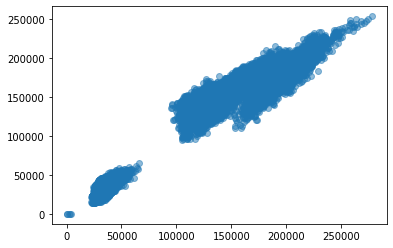

In [36]:
plt.scatter(nem_data['demand'], nem_data['totalg'], alpha=0.5)
plt.show()

In [37]:
nem_data['test'] = nem_data[energy_profile + ['net_import']].sum(axis = 1, skipna = True)
nem_data['test'] = nem_data['test'].astype('int') 
nem_data['test'].value_counts()

100    13420
99      4695
Name: test, dtype: int64

In [38]:
nem_data.drop(columns=['test'], inplace = True)

In [39]:
nem_data.drop(columns=['total', 'totalg'], inplace = True)

In [40]:
nem_data.columns

Index(['region', 'datetime', 'bagasse', 'battery_discharging', 'blackcoal',
       'browncoal', 'diesel', 'gas', 'hydro', 'kerosene', 'solar',
       'solar_rooftop', 'wind', 'demand', 'rrp', 'year', 'net_import',
       'export'],
      dtype='object')

In [41]:
# # drop redundant cols and save as train
# nem_data = nem_data.drop(columns = energy_list)#.to_pickle('data/nem_train.pkl')
# nem_data = nem_data.drop(columns = ['total', 'totalg','import','export', 'export_per'])
nem_data.columns = ['state', 'datetime', 'bagasse', 'batterys', 'blackcoal',
       'browncoal', 'diesel', 'gas', 'hydro', 'kerosene', 'solar', 'solar_rooftop', 'wind',
       'demand', 'rrp', 'year', 'net_import', 'export']

nem_data.to_pickle('data/nem_train.pkl')

In [42]:
nem_data.shape

(18115, 18)